In [1]:
from clearml import Task
import numpy as np
import random
import os
import optuna

import joblib
import pandas as pd
import optuna.visualization as vis
import matplotlib.pyplot as plt

from pathlib import Path
from clearml import Logger
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit

from src import data_preprocessing as dp
from src import pipeline as pl
from src import feature_engineering as fe
from src.model_evaluation import evaluate
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

SEED = 42 # vẫn phải chọn random của model đấy

# Python, NumPy
random.seed(SEED)
np.random.seed(SEED) 

# Hash seed cho Python interpreter (ảnh hưởng tới dict order)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Giới hạn luồng tính toán song song (để tránh floating-point nondeterminism)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# tạo sampler của Optuna có seed cố định
sampler = optuna.samplers.TPESampler(seed=SEED)


c:\Users\Admin\Documents\ML\group1\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# 1. Load raw Data
df = dp.load_data(r"data\raw data\Hanoi Daily 10 years.csv")


# 2. basic preprocessing for all data set
df = dp.basic_preprocessing(df=df)

# 3. chia train, val, test (tỉ lệ 70/15/15)
target_col = 'temp'
train_size = 0.7
val_size = 0.15
n = len(df)

train_df = df.iloc[:int(train_size*n)]
val_df = df.iloc[int(train_size*n):int((train_size+val_size)*n)]
test_df = df.iloc[int((train_size+val_size)*n):]

# 4. Fit và transform trên preprocessing pipeline
pipeline1 = pl.build_preprocessing_pipeline()

# fit trên train
pipeline1.fit(train_df)

# transform 
train_processed = pipeline1.transform(train_df)
val_processed = pipeline1.transform(val_df)
test_processed = pipeline1.transform(test_df)


# Tạo feature engineering
column_lag = ['tempmax', 'tempmin', 'dew', 'humidity', 'precip',
    'precipprob', 'precipcover', 'windgust', 'windspeed',
    'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 
    'pressure_temp_index', 'wind_temp_index', 'temp_range', 'dew_spread']

train_feat = fe.feature_engineering(train_processed, column= column_lag)
val_feat = fe.feature_engineering(val_processed, column= column_lag)
test_feat = fe.feature_engineering(test_processed, column= column_lag)
print(train_feat.shape)

 Loaded data with shape: (3660, 33)
Dropped column: 'description'
Dropped column: 'icon'
Dropped column: 'stations'
Dropped column: 'name'
(2562, 258)


In [4]:
# Chia X, y riêng biệt
X_train, y_train = train_feat.drop(columns=[target_col]), train_df[target_col]
X_val, y_val = val_feat.drop(columns=[target_col]), val_df[target_col]
X_test, y_test = test_feat.drop(columns=[target_col]), test_df[target_col]

print(f"Train: {X_train.shape, y_train.shape}, Val: {X_val.shape, y_val.shape}, Test: {X_test.shape, y_test.shape}")

Train: ((2562, 257), (2562,)), Val: ((549, 257), (549,)), Test: ((549, 257), (549,))


In [5]:
# không để drop highly correlated ở preprocessing nữa, chuyển sang ở feature selection
from src import feature_selection as fs
dropHighCorr = fs.DropHighlyCorrelated()
dropHighCorr.fit(X_train)
X_train = dropHighCorr.transform(X_train)
X_val = dropHighCorr.transform(X_val)
X_test = dropHighCorr.transform(X_test)


In [6]:
fs_pipeline_GB = pl.build_GB_featture_engineering_pipeline()
# GB importance
# fit trên train
X_train = fs_pipeline_GB.fit_transform(X_train, y_train)

# transform 
X_train = fs_pipeline_GB.transform(X_train)
X_val = fs_pipeline_GB.transform(X_val)
X_test = fs_pipeline_GB.transform(X_test)

In [13]:
X_train.columns

Index(['feelslike_lag_1', 'pressure_temp_index_roll_mean_14', 'sunrise_lag_1',
       'solar_temp_index_lag_1', 'winddir_lag_1', 'windspeed_lag_1',
       'sealevelpressure_roll_mean_14', 'windgust_lag_1', 'humidity_lag_1',
       'day_length_lag_1', 'windgust_roll_mean_3', 'dew_spread_lag_1',
       'visibility_lag_1', 'dew_roll_mean_3', 'precip_lag_2',
       'temp_roll_std_7', 'temp_range_lag_1', 'precipcover_roll_mean_3',
       'precip_lag_1', 'sealevelpressure_roll_std_14', 'humidity_roll_mean_3',
       'precipcover_lag_1', 'tempmax_lag_7', 'dew_spread_lag_4',
       'conditions_lag_1', 'visibility_lag_2', 'month_lag_1',
       'temp_range_roll_std_14', 'windgust_lag_4',
       'sealevelpressure_roll_std_3'],
      dtype='object')

In [ ]:
# chưa có feature selection, vẫn còn đủ temp lag 1, ... 252 features
# 1. RF
## Default
# a. Validation metrics: {'RMSE': 2.1278075895022885, 'R2': 0.8297628223226209, 'MAPE': 7.013125189028322}
# b. Test metrics: {'RMSE': 1.7168173002419687, 'R2': 0.8638144750921892, 'MAPE': 5.359437239042012}

## Best parameter
# Validation metrics: {'RMSE': 1.6388776242029133, 'R2': 0.8990089808287993, 'MAPE': 5.741406234570231}
# Test metrics: {'RMSE': 1.4337918013739446, 'R2': 0.9050150119360206, 'MAPE': 4.584963631819218}


# 2. Extra Tree
## Default
# Validation metrics: {'RMSE': 1.5501069852687441, 'R2': 0.9096531427481926, 'MAPE': 5.289823867518864}
# Test metrics: {'RMSE': 1.4094799560393934, 'R2': 0.9082088955219491, 'MAPE': 4.494487229026149}

## Best parameter
# Validation metrics: {'RMSE': 1.4981094962144423, 'R2': 0.9156127533286983, 'MAPE': 5.13799909932879}
# Test metrics: {'RMSE': 1.3558239003827515, 'R2': 0.9150644784751033, 'MAPE': 4.317549688535942}

# 3. GB
## Default
# Validation metrics: {'RMSE': 1.479398688181336, 'R2': 0.9177075178532362, 'MAPE': 5.0692414857715775}
# Test metrics: {'RMSE': 1.3534994389764416, 'R2': 0.9153554603683042, 'MAPE': 4.1845167790637126}

## Best parameter
# Validation metrics: {'RMSE': 1.5011458815829, 'R2': 0.9152703326059204, 'MAPE': 5.158944802837902}
# Test metrics: {'RMSE': 1.3430800523462543, 'R2': 0.9166536500947113, 'MAPE': 4.216884591360309}
Task.current_task().close()

### Gradient Boosting 

In [ ]:
# mỗi lần chạy xong, thì tạo task mới
# Tạo task mới trong project Temperature Forecasting
# Task.current_task().close()
task_gb = Task.init(
    project_name="Temperature Forecasting",     # tên project (nếu chưa có sẽ tự tạo)
    task_name="GradBoosting Tuning", # tên task mới
    task_type=Task.TaskTypes.optimizer            # loại task (training / testing / optimizer ...)
)

# print("✅ Task created successfully!")
print("Task ID:", task_gb.id)

ClearML Task: created new task id=beee3945002f447293344e69f2c53b2b
ClearML results page: https://app.clear.ml/projects/01d8ce929f0243de9a9d3adf48970730/experiments/beee3945002f447293344e69f2c53b2b/output/log
Task ID: beee3945002f447293344e69f2c53b2b


ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start
2025-10-21 19:31:17,312 - clearml.storage - INFO - Uploading: 1.26MB from c:/Users/Admin/Documents/ML/group1/models/Tuning_GradBoosting_model.pkl


█████████████████████████████████ 100% | 1.26/1.26 MB [00:04<00:00,  3.75s/MB]: 


In [9]:
task_grad = Task.get_task(task_id="beee3945002f447293344e69f2c53b2b")
logger_grad = task_grad.get_logger()

In [10]:
## A. default hyper parameter
# 1. fit 
model_grad = GradientBoostingRegressor(
    loss='squared_error', # Hàm mất mát, mặc định squared_error
    learning_rate=0.1,
    n_estimators=100,    # Số lượng cây boosting, mặc định 100
    subsample=1.0,      # Tỉ lệ mẫu dùng mỗi vòng (1.0 = full dataset)
    criterion='friedman_mse',   # Tiêu chí chia node, mặc định friedman_mse
    min_samples_split=2,     # Số mẫu tối thiểu trong leaf
    min_samples_leaf=1,  # Số mẫu tối thiểu trong leaf
    min_weight_fraction_leaf=0.0,   # Tỷ lệ trọng số tối thiểu trong leaf
    max_depth=3,    # Độ sâu tối đa của mỗi cây (default = 3)
    min_impurity_decrease=0.0,
    random_state=42,
    max_features=None,   # Số lượng feature xem xét khi chia, None = tất cả
    alpha=0.9,    # Dành cho loss='huber' hoặc 'quantile'
    max_leaf_nodes=None,     # Số leaf tối đa mỗi cây
    warm_start=False,   # để False khi tuning, Dùng để tiếp tục huấn luyện model cũ
    #validation_fraction= 0.1,   # ❌ tránh dùng để không leak
    n_iter_no_change=None,      # ❌ tránh auto validation split
    tol=1e-4,       # Ngưỡng dừng sớm cho early stopping
    ccp_alpha=0.0  # Complexity pruning, mặc định 0
)

model_grad.fit(X_train, y_train) 

# 2. predict
y_pred_val = model_grad.predict(X_val) 
y_pred_test = model_grad.predict(X_test)


In [11]:
# Lấy feature importance
importances_grad = model_grad.feature_importances_

# Tạo DataFrame hiển thị
feat_importance_grad = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances_grad
}).sort_values(by='Importance', ascending=False)

print(feat_importance_grad)

                             Feature  Importance
0                    feelslike_lag_1    0.826917
1   pressure_temp_index_roll_mean_14    0.050166
2                      sunrise_lag_1    0.043052
3             solar_temp_index_lag_1    0.015197
4                      winddir_lag_1    0.012260
5                    windspeed_lag_1    0.008932
6      sealevelpressure_roll_mean_14    0.008391
7                     windgust_lag_1    0.006775
8                     humidity_lag_1    0.006270
9                   day_length_lag_1    0.002715
10              windgust_roll_mean_3    0.002405
11                  dew_spread_lag_1    0.001804
15                   temp_roll_std_7    0.001410
12                  visibility_lag_1    0.001320
16                  temp_range_lag_1    0.001101
27            temp_range_roll_std_14    0.001100
13                   dew_roll_mean_3    0.000953
21                 precipcover_lag_1    0.000935
25                  visibility_lag_2    0.000901
22                  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


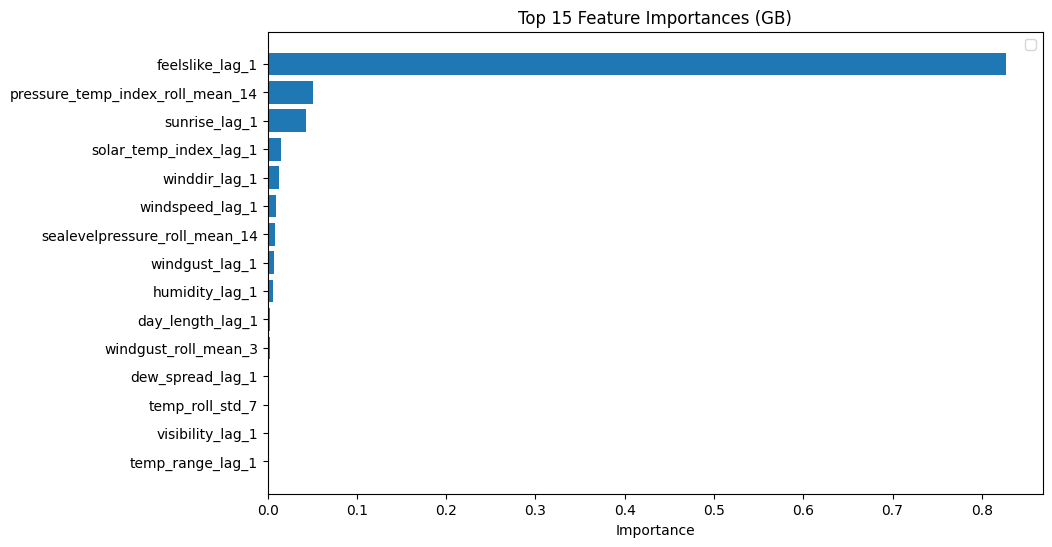

In [14]:
plt.figure(figsize=(10, 6))
plt.barh(feat_importance_grad['Feature'][:15], feat_importance_grad['Importance'][:15])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (GB)")
plt.xlabel("Importance")
plt.show()

In [15]:
# Đánh giá sơ bộ trước khi tune

# 3. Evaluate on validation
defGrad_val_metrics = evaluate(y_val, y_pred_val)
print("Validation metrics:", defGrad_val_metrics)

# 4. Evaluate on test
defGrad_test_metrics = evaluate(y_test, y_pred_test)
print("Test metrics:", defGrad_test_metrics)

# 5. Save model 
model_path = r'models/GradBoosting_model.pkl' 
joblib.dump(model_grad, model_path)
print(f"ExtraTree model saved to {model_path}")

# 6 Log lên ClearML
logger_grad.report_scalar("Default Metrics", "RMSE_val", defGrad_val_metrics["RMSE"], iteration=0)
logger_grad.report_scalar("Default Metrics", "R2_val", defGrad_val_metrics["R2"], iteration=0)
logger_grad.report_scalar("Default Metrics", "MAPE_val", defGrad_val_metrics["MAPE"], iteration=0)
logger_grad.report_scalar("Default Metrics", "RMSE_test", defGrad_test_metrics["RMSE"], iteration=0)
logger_grad.report_scalar("Default Metrics", "R2_test", defGrad_test_metrics["R2"], iteration=0)
logger_grad.report_scalar("Default Metrics", "MAPE_test", defGrad_test_metrics["MAPE"], iteration=0)


task_grad.upload_artifact("Default Metrics", {
    "Validation": defGrad_val_metrics,
    "Test": defGrad_test_metrics
})


Validation metrics: {'RMSE': 1.451543321963491, 'R2': 0.9207772876005071, 'MAPE': 4.935673482940297}
Test metrics: {'RMSE': 1.3579157812057445, 'R2': 0.9148021847440567, 'MAPE': 4.28077045100291}
ExtraTree model saved to models/GradBoosting_model.pkl


True

In [16]:
## B. Hyperparameter tuning cho Gradient Boosting
def objective(trial):
    # === 1. Định nghĩa không gian hyperparameter ===
    params = {
        'loss': trial.suggest_categorical('loss', ['squared_error', 'huber']),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),   # default = 0.1
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),       # default = 100
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),            # default = 1.0
        'criterion': 'friedman_mse',                                        # default
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10), # default = 2
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),    # default = 1
        'max_depth': trial.suggest_int('max_depth', 2, 7),                  # default = 3
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.2),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 50, 500),     # default = None
        'alpha': trial.suggest_float('alpha', 0.85, 0.95),                  # chỉ dùng nếu loss='huber' hoặc 'quantile'
        'tol': 1e-4,
        'ccp_alpha': 0.0,
        'random_state': 42
        # ⚠️ Không dùng early stopping (n_iter_no_change, validation_fraction)
        # vì đây là time series → tránh leak
    }

    # === 2. TimeSeriesSplit CV ===
    cv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_idx, val_idx in cv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # === 3. Train model ===
        model = GradientBoostingRegressor(**params)
        model.fit(X_tr, y_tr)
        y_pred_val = model.predict(X_val)

        metrics = evaluate(y_val, y_pred_val)
        rmse_scores.append(metrics['RMSE'])

    mean_rmse = np.mean(rmse_scores)

    # === 4. Log kết quả lên ClearML ===
    # (a) Log RMSE cho mỗi trial
    logger_grad.report_scalar(
        title='Optuna Tuning - GradientBoosting',
        series='Trial RMSE',
        value=mean_rmse,
        iteration=trial.number
    )

    # (b) Log toàn bộ tham số của trial (bảng tóm tắt)
    params_table = pd.DataFrame([params])
    logger_grad.report_table(
        title=f"Trial {trial.number} Parameters",
        series="params",
        iteration=trial.number,
        table_plot=params_table
    )

    # === 5. Trả về RMSE trung bình của các fold để Optuna minimize ===
    return mean_rmse


In [17]:
# === 3. Chạy Optuna study cho ExtraTrees ===
study_grad = optuna.create_study(
    direction='minimize',   # mục tiêu: giảm RMSE
    sampler=sampler
)

# Tiến hành tối ưu
study_grad.optimize(objective, n_trials=50, show_progress_bar=True)

# === 4. In kết quả tốt nhất ===
print("Best parameters:", study_grad.best_trial.params)
print("Best RMSE:", study_grad.best_value)


[I 2025-10-21 19:11:34,495] A new study created in memory with name: no-name-3524912d-2955-41ed-9114-d52d479e271d
Best trial: 0. Best value: 1.59351:   2%|▏         | 1/50 [00:19<15:46, 19.32s/it]

[I 2025-10-21 19:11:53,811] Trial 0 finished with value: 1.5935054955919967 and parameters: {'loss': 'huber', 'learning_rate': 0.22227824312530747, 'n_estimators': 639, 'subsample': 0.6624074561769746, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 7, 'min_impurity_decrease': 0.12022300234864176, 'max_features': None, 'max_leaf_nodes': 425, 'alpha': 0.8712339110678275}. Best is trial 0 with value: 1.5935054955919967.


Best trial: 1. Best value: 1.51582:   4%|▍         | 2/50 [00:46<18:56, 23.68s/it]

[I 2025-10-21 19:12:20,552] Trial 1 finished with value: 1.5158239985156112 and parameters: {'loss': 'huber', 'learning_rate': 0.09823025045826593, 'n_estimators': 572, 'subsample': 0.7727780074568463, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 2, 'min_impurity_decrease': 0.058428929707043636, 'max_features': None, 'max_leaf_nodes': 140, 'alpha': 0.9014234438413611}. Best is trial 1 with value: 1.5158239985156112.


Best trial: 1. Best value: 1.51582:   6%|▌         | 3/50 [00:50<11:41, 14.92s/it]

[I 2025-10-21 19:12:25,051] Trial 2 finished with value: 1.6302963885598682 and parameters: {'loss': 'squared_error', 'learning_rate': 0.1861880070514171, 'n_estimators': 253, 'subsample': 0.6260206371941118, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 6, 'min_impurity_decrease': 0.06092275383467414, 'max_features': 'log2', 'max_leaf_nodes': 105, 'alpha': 0.899517691011127}. Best is trial 1 with value: 1.5158239985156112.


Best trial: 1. Best value: 1.51582:   8%|▊         | 4/50 [01:13<13:56, 18.18s/it]

[I 2025-10-21 19:12:48,223] Trial 3 finished with value: 1.5565247948158343 and parameters: {'loss': 'huber', 'learning_rate': 0.0850461946640049, 'n_estimators': 696, 'subsample': 0.7246844304357644, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_depth': 3, 'min_impurity_decrease': 0.19391692555291173, 'max_features': 'log2', 'max_leaf_nodes': 319, 'alpha': 0.9421874235023117}. Best is trial 1 with value: 1.5158239985156112.


Best trial: 4. Best value: 1.44671:  10%|█         | 5/50 [01:49<18:18, 24.41s/it]

[I 2025-10-21 19:13:23,688] Trial 4 finished with value: 1.4467128318118392 and parameters: {'loss': 'huber', 'learning_rate': 0.023115913784056037, 'n_estimators': 393, 'subsample': 0.7554709158757928, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_depth': 4, 'min_impurity_decrease': 0.05618690193747616, 'max_features': None, 'max_leaf_nodes': 83, 'alpha': 0.9486886936600517}. Best is trial 4 with value: 1.4467128318118392.


Best trial: 4. Best value: 1.44671:  12%|█▏        | 6/50 [01:56<13:43, 18.72s/it]

[I 2025-10-21 19:13:31,355] Trial 5 finished with value: 1.5535102854493936 and parameters: {'loss': 'squared_error', 'learning_rate': 0.011601413965844696, 'n_estimators': 834, 'subsample': 0.8827429375390468, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_depth': 2, 'min_impurity_decrease': 0.07169314570885453, 'max_features': 'log2', 'max_leaf_nodes': 199, 'alpha': 0.8563558350286024}. Best is trial 4 with value: 1.4467128318118392.


Best trial: 4. Best value: 1.44671:  14%|█▍        | 7/50 [02:09<12:06, 16.89s/it]

[I 2025-10-21 19:13:44,481] Trial 6 finished with value: 1.6304652037507545 and parameters: {'loss': 'huber', 'learning_rate': 0.22158579171803858, 'n_estimators': 674, 'subsample': 0.9548850970305306, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_depth': 6, 'min_impurity_decrease': 0.1521570097233795, 'max_features': 'log2', 'max_leaf_nodes': 285, 'alpha': 0.8927541018358549}. Best is trial 4 with value: 1.4467128318118392.


Best trial: 4. Best value: 1.44671:  16%|█▌        | 8/50 [02:26<11:42, 16.74s/it]

[I 2025-10-21 19:14:00,890] Trial 7 finished with value: 1.4814744652866412 and parameters: {'loss': 'huber', 'learning_rate': 0.019114463849152934, 'n_estimators': 673, 'subsample': 0.7257423924305306, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_depth': 3, 'min_impurity_decrease': 0.08207658460712595, 'max_features': 'sqrt', 'max_leaf_nodes': 180, 'alpha': 0.8661221287254004}. Best is trial 4 with value: 1.4467128318118392.


Best trial: 4. Best value: 1.44671:  18%|█▊        | 9/50 [02:34<09:39, 14.14s/it]

[I 2025-10-21 19:14:09,330] Trial 8 finished with value: 1.6136963800252022 and parameters: {'loss': 'squared_error', 'learning_rate': 0.19368708938802282, 'n_estimators': 885, 'subsample': 0.9214688307596458, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 5, 'min_impurity_decrease': 0.1614880310328125, 'max_features': 'sqrt', 'max_leaf_nodes': 152, 'alpha': 0.8927107788626256}. Best is trial 4 with value: 1.4467128318118392.


Best trial: 9. Best value: 1.43592:  20%|██        | 10/50 [03:22<16:25, 24.63s/it]

[I 2025-10-21 19:14:57,432] Trial 9 finished with value: 1.435916025853116 and parameters: {'loss': 'huber', 'learning_rate': 0.012016117854045303, 'n_estimators': 560, 'subsample': 0.7669644012595116, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 4, 'min_impurity_decrease': 0.18858194078250384, 'max_features': None, 'max_leaf_nodes': 213, 'alpha': 0.947178208272096}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  22%|██▏       | 11/50 [03:32<12:55, 19.87s/it]

[I 2025-10-21 19:15:06,529] Trial 10 finished with value: 1.459464789655881 and parameters: {'loss': 'squared_error', 'learning_rate': 0.11548102535027302, 'n_estimators': 106, 'subsample': 0.8559192772506938, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 4, 'min_impurity_decrease': 0.014824035653036832, 'max_features': None, 'max_leaf_nodes': 497, 'alpha': 0.9262876279815506}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  24%|██▍       | 12/50 [04:04<14:57, 23.61s/it]

[I 2025-10-21 19:15:38,699] Trial 11 finished with value: 1.4761559552735444 and parameters: {'loss': 'huber', 'learning_rate': 0.06004912214289325, 'n_estimators': 406, 'subsample': 0.8165174529401429, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 4, 'min_impurity_decrease': 0.01494546178157534, 'max_features': None, 'max_leaf_nodes': 77, 'alpha': 0.9499324790016894}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  26%|██▌       | 13/50 [04:43<17:26, 28.29s/it]

[I 2025-10-21 19:16:17,744] Trial 12 finished with value: 1.4801857451909515 and parameters: {'loss': 'huber', 'learning_rate': 0.04814667210287845, 'n_estimators': 413, 'subsample': 0.765145626391539, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 5, 'min_impurity_decrease': 0.10939072049243478, 'max_features': None, 'max_leaf_nodes': 54, 'alpha': 0.9261950998455413}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  28%|██▊       | 14/50 [05:02<15:23, 25.66s/it]

[I 2025-10-21 19:16:37,332] Trial 13 finished with value: 1.5923015324172343 and parameters: {'loss': 'huber', 'learning_rate': 0.2750858916243106, 'n_estimators': 424, 'subsample': 0.7071446743883983, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 3, 'min_impurity_decrease': 0.1998022171858216, 'max_features': None, 'max_leaf_nodes': 237, 'alpha': 0.9289965688531333}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  30%|███       | 15/50 [05:23<14:03, 24.10s/it]

[I 2025-10-21 19:16:57,822] Trial 14 finished with value: 1.5266383616742583 and parameters: {'loss': 'huber', 'learning_rate': 0.1334209446655103, 'n_estimators': 283, 'subsample': 0.7983601084096518, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 4, 'min_impurity_decrease': 0.03094596072615125, 'max_features': None, 'max_leaf_nodes': 339, 'alpha': 0.9376635303225268}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  32%|███▏      | 16/50 [06:10<17:39, 31.16s/it]

[I 2025-10-21 19:17:45,383] Trial 15 finished with value: 1.4881005792745705 and parameters: {'loss': 'huber', 'learning_rate': 0.04956215859581681, 'n_estimators': 503, 'subsample': 0.668147523279367, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_depth': 5, 'min_impurity_decrease': 0.13330712786154378, 'max_features': None, 'max_leaf_nodes': 246, 'alpha': 0.9143821378407033}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  34%|███▍      | 17/50 [06:37<16:20, 29.71s/it]

[I 2025-10-21 19:18:11,721] Trial 16 finished with value: 1.472008614715834 and parameters: {'loss': 'huber', 'learning_rate': 0.011683522839419761, 'n_estimators': 991, 'subsample': 0.850967930645987, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 3, 'min_impurity_decrease': 0.04225417279386334, 'max_features': 'sqrt', 'max_leaf_nodes': 384, 'alpha': 0.9476863371745423}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  36%|███▌      | 18/50 [07:23<18:26, 34.58s/it]

[I 2025-10-21 19:18:57,646] Trial 17 finished with value: 1.5019404970128427 and parameters: {'loss': 'huber', 'learning_rate': 0.06891407658679836, 'n_estimators': 265, 'subsample': 0.7597178593275226, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 6, 'min_impurity_decrease': 0.08637155719993538, 'max_features': None, 'max_leaf_nodes': 120, 'alpha': 0.9132630392762318}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  38%|███▊      | 19/50 [07:49<16:31, 32.00s/it]

[I 2025-10-21 19:19:23,620] Trial 18 finished with value: 1.5610200289960168 and parameters: {'loss': 'squared_error', 'learning_rate': 0.14810902842972024, 'n_estimators': 509, 'subsample': 0.6031982378141749, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 4, 'min_impurity_decrease': 0.16771741334118312, 'max_features': None, 'max_leaf_nodes': 207, 'alpha': 0.934482578358602}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  40%|████      | 20/50 [07:58<12:34, 25.14s/it]

[I 2025-10-21 19:19:32,776] Trial 19 finished with value: 1.49807794201903 and parameters: {'loss': 'huber', 'learning_rate': 0.03762572046063529, 'n_estimators': 127, 'subsample': 0.9834399962929773, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_depth': 5, 'min_impurity_decrease': 0.09614074077528068, 'max_features': 'sqrt', 'max_leaf_nodes': 95, 'alpha': 0.9164579119127989}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  42%|████▏     | 21/50 [08:15<10:57, 22.66s/it]

[I 2025-10-21 19:19:49,664] Trial 20 finished with value: 1.6151612515661644 and parameters: {'loss': 'huber', 'learning_rate': 0.2969437641043133, 'n_estimators': 342, 'subsample': 0.8180545123987003, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 7, 'min_impurity_decrease': 0.14554751073424213, 'max_features': None, 'max_leaf_nodes': 167, 'alpha': 0.877909956470797}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  44%|████▍     | 22/50 [08:23<08:32, 18.30s/it]

[I 2025-10-21 19:19:57,783] Trial 21 finished with value: 1.4637943258534312 and parameters: {'loss': 'squared_error', 'learning_rate': 0.11173769385389651, 'n_estimators': 102, 'subsample': 0.8670731885908882, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 4, 'min_impurity_decrease': 0.0036832257690606104, 'max_features': None, 'max_leaf_nodes': 495, 'alpha': 0.9254543648368806}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  46%|████▌     | 23/50 [08:39<07:55, 17.62s/it]

[I 2025-10-21 19:20:13,808] Trial 22 finished with value: 1.4652453708841846 and parameters: {'loss': 'squared_error', 'learning_rate': 0.12095332660665097, 'n_estimators': 198, 'subsample': 0.9083707096944635, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 4, 'min_impurity_decrease': 0.031208905496107626, 'max_features': None, 'max_leaf_nodes': 490, 'alpha': 0.9403856707923428}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  48%|████▊     | 24/50 [09:12<09:36, 22.17s/it]

[I 2025-10-21 19:20:46,612] Trial 23 finished with value: 1.4965777673238752 and parameters: {'loss': 'squared_error', 'learning_rate': 0.07815786729497494, 'n_estimators': 579, 'subsample': 0.8496432649904782, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3, 'min_impurity_decrease': 0.019128404487679773, 'max_features': None, 'max_leaf_nodes': 419, 'alpha': 0.9496591855595929}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  50%|█████     | 25/50 [10:05<13:09, 31.59s/it]

[I 2025-10-21 19:21:40,167] Trial 24 finished with value: 1.472326912990265 and parameters: {'loss': 'squared_error', 'learning_rate': 0.04136135388557521, 'n_estimators': 801, 'subsample': 0.7927875458629294, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 4, 'min_impurity_decrease': 0.047049501693023674, 'max_features': None, 'max_leaf_nodes': 289, 'alpha': 0.9324005985818247}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  52%|█████▏    | 26/50 [10:28<11:32, 28.87s/it]

[I 2025-10-21 19:22:02,699] Trial 25 finished with value: 1.5684935132220945 and parameters: {'loss': 'squared_error', 'learning_rate': 0.16458534897494634, 'n_estimators': 344, 'subsample': 0.6934645428171423, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 5, 'min_impurity_decrease': 0.001988536677006835, 'max_features': None, 'max_leaf_nodes': 364, 'alpha': 0.9189579790434649}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  54%|█████▍    | 27/50 [10:36<08:39, 22.57s/it]

[I 2025-10-21 19:22:10,563] Trial 26 finished with value: 1.478405888710259 and parameters: {'loss': 'squared_error', 'learning_rate': 0.030197986740731438, 'n_estimators': 163, 'subsample': 0.7495743056061102, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3, 'min_impurity_decrease': 0.17434374434379163, 'max_features': None, 'max_leaf_nodes': 236, 'alpha': 0.940401748122941}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  56%|█████▌    | 28/50 [11:22<10:53, 29.68s/it]

[I 2025-10-21 19:22:56,849] Trial 27 finished with value: 1.4971166130325881 and parameters: {'loss': 'huber', 'learning_rate': 0.09659360444950862, 'n_estimators': 479, 'subsample': 0.829992691292269, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_depth': 4, 'min_impurity_decrease': 0.046519877797775055, 'max_features': None, 'max_leaf_nodes': 50, 'alpha': 0.9228514692891076}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  58%|█████▊    | 29/50 [11:24<07:31, 21.51s/it]

[I 2025-10-21 19:22:59,280] Trial 28 finished with value: 1.5329161668110252 and parameters: {'loss': 'squared_error', 'learning_rate': 0.06174436010444494, 'n_estimators': 206, 'subsample': 0.9025259021741168, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 2, 'min_impurity_decrease': 0.02511613192596358, 'max_features': 'sqrt', 'max_leaf_nodes': 449, 'alpha': 0.9423294732824092}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  60%|██████    | 30/50 [11:44<07:02, 21.11s/it]

[I 2025-10-21 19:23:19,448] Trial 29 finished with value: 1.643688539489835 and parameters: {'loss': 'huber', 'learning_rate': 0.16515327595632054, 'n_estimators': 763, 'subsample': 0.6695555777599758, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 5, 'min_impurity_decrease': 0.12119057184604064, 'max_features': 'log2', 'max_leaf_nodes': 392, 'alpha': 0.9072743312115124}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  62%|██████▏   | 31/50 [12:17<07:48, 24.64s/it]

[I 2025-10-21 19:23:52,332] Trial 30 finished with value: 1.5682734507604024 and parameters: {'loss': 'huber', 'learning_rate': 0.2461830672491817, 'n_estimators': 593, 'subsample': 0.7898046733627585, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 4, 'min_impurity_decrease': 0.18377615466317512, 'max_features': None, 'max_leaf_nodes': 322, 'alpha': 0.9322994860512883}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  64%|██████▍   | 32/50 [12:26<05:54, 19.71s/it]

[I 2025-10-21 19:24:00,525] Trial 31 finished with value: 1.4587447627949683 and parameters: {'loss': 'squared_error', 'learning_rate': 0.10598581155258721, 'n_estimators': 104, 'subsample': 0.8733177224383363, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 4, 'min_impurity_decrease': 0.002251625013406514, 'max_features': None, 'max_leaf_nodes': 488, 'alpha': 0.9277841823198698}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  66%|██████▌   | 33/50 [12:51<06:03, 21.38s/it]

[I 2025-10-21 19:24:25,820] Trial 32 finished with value: 1.505971252618841 and parameters: {'loss': 'squared_error', 'learning_rate': 0.11702549965570182, 'n_estimators': 336, 'subsample': 0.9369456401500476, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 4, 'min_impurity_decrease': 0.013756743933598135, 'max_features': None, 'max_leaf_nodes': 454, 'alpha': 0.9457858883983188}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  68%|██████▊   | 34/50 [13:00<04:43, 17.73s/it]

[I 2025-10-21 19:24:35,020] Trial 33 finished with value: 1.4752439287565386 and parameters: {'loss': 'squared_error', 'learning_rate': 0.09529395378999087, 'n_estimators': 169, 'subsample': 0.8859357281437735, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 3, 'min_impurity_decrease': 0.06760143482579126, 'max_features': None, 'max_leaf_nodes': 457, 'alpha': 0.9076041905451053}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  70%|███████   | 35/50 [13:14<04:09, 16.60s/it]

[I 2025-10-21 19:24:49,007] Trial 34 finished with value: 1.5221946352463096 and parameters: {'loss': 'squared_error', 'learning_rate': 0.13906156134735506, 'n_estimators': 227, 'subsample': 0.7391424340389634, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 4, 'min_impurity_decrease': 0.0561227997906673, 'max_features': None, 'max_leaf_nodes': 421, 'alpha': 0.9342599464269512}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  72%|███████▏  | 36/50 [13:19<03:05, 13.27s/it]

[I 2025-10-21 19:24:54,490] Trial 35 finished with value: 1.5143400561414169 and parameters: {'loss': 'squared_error', 'learning_rate': 0.0814500789938589, 'n_estimators': 292, 'subsample': 0.8507683070747691, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 5, 'min_impurity_decrease': 0.033696015378168784, 'max_features': 'log2', 'max_leaf_nodes': 473, 'alpha': 0.9204302708914095}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  74%|███████▍  | 37/50 [13:26<02:25, 11.18s/it]

[I 2025-10-21 19:25:00,794] Trial 36 finished with value: 1.490768490839028 and parameters: {'loss': 'squared_error', 'learning_rate': 0.18247069002121052, 'n_estimators': 135, 'subsample': 0.7808772137390048, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 2, 'min_impurity_decrease': 0.0008765750101316413, 'max_features': None, 'max_leaf_nodes': 136, 'alpha': 0.9441466960701543}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  76%|███████▌  | 38/50 [13:44<02:40, 13.36s/it]

[I 2025-10-21 19:25:19,231] Trial 37 finished with value: 1.4847319972406967 and parameters: {'loss': 'huber', 'learning_rate': 0.02618850045621976, 'n_estimators': 627, 'subsample': 0.8197970124465569, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 3, 'min_impurity_decrease': 0.05812179121708118, 'max_features': 'log2', 'max_leaf_nodes': 264, 'alpha': 0.8960375477181002}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  78%|███████▊  | 39/50 [14:23<03:51, 21.02s/it]

[I 2025-10-21 19:25:58,143] Trial 38 finished with value: 1.5227404345342825 and parameters: {'loss': 'squared_error', 'learning_rate': 0.10611490414279899, 'n_estimators': 738, 'subsample': 0.8714412410229431, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 6, 'min_impurity_decrease': 0.07189859720013471, 'max_features': None, 'max_leaf_nodes': 185, 'alpha': 0.9372154175081593}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  80%|████████  | 40/50 [15:11<04:50, 29.03s/it]

[I 2025-10-21 19:26:45,838] Trial 39 finished with value: 1.4790130569986883 and parameters: {'loss': 'huber', 'learning_rate': 0.05554771625436786, 'n_estimators': 544, 'subsample': 0.7038383831663181, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 4, 'min_impurity_decrease': 0.012069436350374713, 'max_features': None, 'max_leaf_nodes': 210, 'alpha': 0.8805935797788503}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  82%|████████▏ | 41/50 [15:23<03:36, 24.06s/it]

[I 2025-10-21 19:26:58,312] Trial 40 finished with value: 1.6106497745565256 and parameters: {'loss': 'huber', 'learning_rate': 0.20987562355884481, 'n_estimators': 435, 'subsample': 0.7393070117962682, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 3, 'min_impurity_decrease': 0.10454377466260051, 'max_features': 'sqrt', 'max_leaf_nodes': 302, 'alpha': 0.9080261965222004}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  84%|████████▍ | 42/50 [15:31<02:33, 19.22s/it]

[I 2025-10-21 19:27:06,226] Trial 41 finished with value: 1.4727788770732684 and parameters: {'loss': 'squared_error', 'learning_rate': 0.12568195889422085, 'n_estimators': 111, 'subsample': 0.8747212869962977, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 4, 'min_impurity_decrease': 0.006987577514449695, 'max_features': None, 'max_leaf_nodes': 485, 'alpha': 0.9267629808422112}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  86%|████████▌ | 43/50 [15:41<01:53, 16.27s/it]

[I 2025-10-21 19:27:15,630] Trial 42 finished with value: 1.465158131361378 and parameters: {'loss': 'squared_error', 'learning_rate': 0.10185933035497963, 'n_estimators': 117, 'subsample': 0.8344190393323836, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 4, 'min_impurity_decrease': 0.021220039328445885, 'max_features': None, 'max_leaf_nodes': 492, 'alpha': 0.9251795310209694}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  88%|████████▊ | 44/50 [15:57<01:38, 16.38s/it]

[I 2025-10-21 19:27:32,268] Trial 43 finished with value: 1.4798045955199857 and parameters: {'loss': 'squared_error', 'learning_rate': 0.11364022228823602, 'n_estimators': 171, 'subsample': 0.8948334618384564, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 5, 'min_impurity_decrease': 0.0356882036880544, 'max_features': None, 'max_leaf_nodes': 441, 'alpha': 0.93039698255721}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  90%|█████████ | 45/50 [16:16<01:25, 17.08s/it]

[I 2025-10-21 19:27:50,975] Trial 44 finished with value: 1.492579464451056 and parameters: {'loss': 'squared_error', 'learning_rate': 0.14824768027370508, 'n_estimators': 229, 'subsample': 0.9325454187511872, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 4, 'min_impurity_decrease': 0.009166540856728057, 'max_features': None, 'max_leaf_nodes': 472, 'alpha': 0.9381762832705577}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  92%|█████████▏| 46/50 [16:21<00:53, 13.35s/it]

[I 2025-10-21 19:27:55,627] Trial 45 finished with value: 1.5129486195374942 and parameters: {'loss': 'squared_error', 'learning_rate': 0.07335228677125527, 'n_estimators': 305, 'subsample': 0.8582622819331827, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 5, 'min_impurity_decrease': 0.01846895094286575, 'max_features': 'log2', 'max_leaf_nodes': 401, 'alpha': 0.9008295594782302}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  94%|█████████▍| 47/50 [17:10<01:12, 24.06s/it]

[I 2025-10-21 19:28:44,658] Trial 46 finished with value: 1.4932247272689925 and parameters: {'loss': 'huber', 'learning_rate': 0.08996553167843488, 'n_estimators': 634, 'subsample': 0.7730873459511247, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 4, 'min_impurity_decrease': 0.08390005931456736, 'max_features': None, 'max_leaf_nodes': 498, 'alpha': 0.944919839138906}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  96%|█████████▌| 48/50 [17:14<00:36, 18.10s/it]

[I 2025-10-21 19:28:48,858] Trial 47 finished with value: 1.7158692832633786 and parameters: {'loss': 'squared_error', 'learning_rate': 0.02008956098020802, 'n_estimators': 101, 'subsample': 0.7206942373142307, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 3, 'min_impurity_decrease': 0.04434973133315737, 'max_features': None, 'max_leaf_nodes': 356, 'alpha': 0.9114859374946556}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592:  98%|█████████▊| 49/50 [17:44<00:21, 21.79s/it]

[I 2025-10-21 19:29:19,262] Trial 48 finished with value: 1.5101824709930702 and parameters: {'loss': 'huber', 'learning_rate': 0.13599209953595934, 'n_estimators': 377, 'subsample': 0.809065458540542, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_depth': 4, 'min_impurity_decrease': 0.0005238406381360885, 'max_features': None, 'max_leaf_nodes': 80, 'alpha': 0.8514117513645384}. Best is trial 9 with value: 1.435916025853116.


Best trial: 9. Best value: 1.43592: 100%|██████████| 50/50 [17:56<00:00, 21.53s/it]

[I 2025-10-21 19:29:31,077] Trial 49 finished with value: 1.4966546055119405 and parameters: {'loss': 'squared_error', 'learning_rate': 0.03727334232939966, 'n_estimators': 468, 'subsample': 0.9532172519243896, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_depth': 5, 'min_impurity_decrease': 0.026469923644511215, 'max_features': 'sqrt', 'max_leaf_nodes': 428, 'alpha': 0.8864503861754216}. Best is trial 9 with value: 1.435916025853116.
Best parameters: {'loss': 'huber', 'learning_rate': 0.012016117854045303, 'n_estimators': 560, 'subsample': 0.7669644012595116, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 4, 'min_impurity_decrease': 0.18858194078250384, 'max_features': None, 'max_leaf_nodes': 213, 'alpha': 0.947178208272096}
Best RMSE: 1.435916025853116


In [18]:
# === 4 Log kết quả tổng hợp ===
task_grad.upload_artifact("Best Parameters", study_grad.best_trial.params)

# Fit lại mô hình với best params
best_model_grad = GradientBoostingRegressor(**study_grad.best_trial.params)
best_model_grad.fit(X_train, y_train)

# Predict
y_pred_val = best_model_grad.predict(X_val)
y_pred_test = best_model_grad.predict(X_test)

# Evaluate on validation
bestGrad_val_metrics = evaluate(y_val, y_pred_val)
print("Validation metrics:", bestGrad_val_metrics)

# Evaluate on test
bestGrad_test_metrics = evaluate(y_test, y_pred_test)
print("Test metrics:", bestGrad_test_metrics)


# 6 Log lên ClearML
logger_grad.report_scalar("Best Metrics", "RMSE_val", bestGrad_val_metrics["RMSE"], iteration=0)
logger_grad.report_scalar("Best Metrics", "R2_val", bestGrad_val_metrics["R2"], iteration=0)
logger_grad.report_scalar("Best Metrics", "MAPE_val", bestGrad_val_metrics["MAPE"], iteration=0)
logger_grad.report_scalar("Best Metrics", "RMSE_test", bestGrad_test_metrics["RMSE"], iteration=0)
logger_grad.report_scalar("Best Metrics", "R2_test", bestGrad_test_metrics["R2"], iteration=0)
logger_grad.report_scalar("Best Metrics", "MAPE_test", bestGrad_test_metrics["MAPE"], iteration=0)


# Upload artifact tổng hợp
task_grad.upload_artifact("Best Metrics", {
    "Validation": bestGrad_val_metrics,
    "Test": bestGrad_test_metrics
})


# Save & upload model
model_path = r'models/Tuning_GradBoosting_model.pkl' 
joblib.dump(best_model_grad, model_path)
print(f"RandomForest model saved to {model_path}")
task_grad.upload_artifact("Best Model", model_path)

Validation metrics: {'RMSE': 1.429960278216999, 'R2': 0.9231157024537284, 'MAPE': 4.804639028578624}
Test metrics: {'RMSE': 1.3227282538361278, 'R2': 0.9191604201502542, 'MAPE': 4.145968732551361}
RandomForest model saved to models/Tuning_GradBoosting_model.pkl


True

In [19]:
# === 6️ Vẽ biểu đồ RMSE theo trial  ===
fig3 = plt.figure(figsize=(7, 4))
plt.plot([t.value for t in study_grad.trials])
plt.xlabel("Trial")
plt.ylabel("RMSE")
plt.title("Optuna RMSE per Trial")

logger_grad.report_matplotlib_figure(
    title="Optuna Performance", 
    series="RMSE Curve", 
    figure=fig3,
    iteration=len(study_grad.trials)
)
plt.close(fig3)


In [20]:
vis.plot_parallel_coordinate(study_grad)

In [21]:
vis.plot_slice(study=study_grad)

In [22]:
vis.plot_param_importances(study=study_grad)

In [23]:
task_grad.close()